# Kaggle

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/daigt-proper-train-dataset/train_drcat_03.csv
/kaggle/input/daigt-proper-train-dataset/train_drcat_02.csv
/kaggle/input/daigt-proper-train-dataset/train_drcat_04.csv
/kaggle/input/daigt-proper-train-dataset/train_drcat_01.csv


---

# Packages

In [2]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

import tensorflow as tf

from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import Flatten, Dense,Dropout,LSTM,Embedding

from tensorflow.keras.callbacks import EarlyStopping


from tensorflow.keras.models import Sequential

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical 

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from IPython.display import clear_output

2024-08-02 22:25:52.900786: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-02 22:25:52.900901: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-02 22:25:53.042017: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
import nltk
from nltk.util import ngrams
from nltk.tokenize import  word_tokenize

In [4]:
def progress(cnt,y,refresh=300):
    if not cnt % refresh:
        clear_output(wait=True)
        progress = cnt * 100 / y

        print("\033[92m━\033[0m"*int(progress/1.7),end="")
        print("-"*int((100 - progress)/1.7),end="")
        print(f" \033[92m{progress:.2f}%\033[0m")

## GPU

In [5]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [6]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Restrict TensorFlow to only use the first GPU
        tf.config.set_visible_devices(gpus[0], 'GPU')
        # Set memory growth to avoid taking up all GPU memory
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

# ***Text Reformulation***
---

# I- Data


In [7]:
data_01 = pd.read_csv('/kaggle/input/daigt-proper-train-dataset/train_drcat_01.csv')
# data_02 = pd.read_csv('/kaggle/input/daigt-proper-train-dataset/train_drcat_02.csv')
# data_03 = pd.read_csv('/kaggle/input/daigt-proper-train-dataset/train_drcat_03.csv')
# data_04 = pd.read_csv('/kaggle/input/daigt-proper-train-dataset/train_drcat_04.csv')
data_01.head()

,text,label,source,fold
0,There are alot reasons to keep our the despise...,0,persuade_corpus,2
1,Driving smart cars that drive by themself has ...,0,persuade_corpus,4
2,"Dear Principal,\n\nI believe that students at ...",0,persuade_corpus,0
3,"Dear Principal,\n\nCommunity service should no...",0,persuade_corpus,0
4,My argument for the development of the driverl...,0,persuade_corpus,3


In [8]:
data_01.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33259 entries, 0 to 33258
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    33259 non-null  object
 1   label   33259 non-null  int64 
 2   source  33259 non-null  object
 3   fold    33259 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 1.0+ MB


In [9]:
data_01.dropna()

,text,label,source,fold
0,There are alot reasons to keep our the despise...,0,persuade_corpus,2
1,Driving smart cars that drive by themself has ...,0,persuade_corpus,4
2,"Dear Principal,\n\nI believe that students at ...",0,persuade_corpus,0
3,"Dear Principal,\n\nCommunity service should no...",0,persuade_corpus,0
4,My argument for the development of the driverl...,0,persuade_corpus,3
...,...,...,...,...
33254,Are driverless cars really necessary? Most of ...,0,persuade_corpus,4
33255,"""Oh man I didn't make the soccer team!"", yelle...",0,persuade_corpus,1
33256,I believe that using this technology could be ...,0,persuade_corpus,0
33257,Texting & Driving\n\nUsing your phone while dr...,0,persuade_corpus,3


In [10]:
data_01.text[100]

'Some schools offer distance schooling for students to be able to learn from home, and would they benefit from it. Should more schools do this where you live. Here are some advantages to schools that do this.\n\nOne advantage to doing distance learning is there is no traveling. Students donÃ\x82Â´t have to come to school everyday, and there parents donÃ\x82Â´t have to bring them either. It is just allot less running around for the students and parents. They dont have to get up so early just to go to school. You just get right out of bed and get your work done.\n\nSchools are doing it now so kids can spend more time with their family. They have to go to school for 8 hours a day ,then come home to spend little time with the family. Kids need that family time rather then going to school all day. The parents can help them do the work if needed. Just getting more support then at school.\n\nI feel like if kids did their work at home they would get more work one. They dont have here friends t

In [11]:
lb_0 = [data_01.text[x] for x in range(len(data_01.text)) if data_01.label[x] == 0]
lb_1 = [data_01.text[x] for x in range(len(data_01.text)) if data_01.label[x] == 1]

In [12]:
max_txt = len((max(lb_0,key=lambda x : len(x.split()))).split())
max_txt

1656

In [13]:
len(lb_0)

25996

In [14]:
sampel = lb_0[:7000]

## GloVe

In [ ]:
!wget https://huggingface.co/stanfordnlp/glove/resolve/main/glove.6B.zip

In [ ]:
!unzip glove.6B.zip

In [ ]:
!ls -lh

In [ ]:
!rm -rf /kaggle/working/glove.6B.300d.txt

In [ ]:
# !head glove.6B.50d.txt

In [15]:
def load_glove_vectors(file_path):
    embeddings_index = {}
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()

            try:
                word = values[0]
                coefs = np.asarray(values[1:], dtype='float32')
            except:
              # red exseption
                print("\033[91m",'='*20,"\033[0m")
                continue
            embeddings_index[word] = coefs
    return embeddings_index

# Specify the path to the GloVe file
glove_file = './glove.6B.100d.txt'

# Load the GloVe vectors
glove = load_glove_vectors(glove_file)

In [16]:
len(glove),glove["hi"].shape

(400001, (100,))

In [17]:
glove_keys = list(glove.keys())
len(glove_keys)

400001

In [55]:
embedding_dim = 100
vocab_size = len(glove) 
embedding_matrix = np.zeros((vocab_size, embedding_dim))

word_index = {word: i for i, word in enumerate(glove.keys(), 0)}
for word, i in word_index.items():
    embedding_vector = glove.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [52]:
embedding_matrix.shape

(400001, 100)

## Glove dict


In [20]:
glove_keys = list(glove.keys())

In [54]:
index2word = {}
word2index = {}


for i in range(len(glove_keys)):
    index2word[i] = glove_keys[i]
    word2index[glove_keys[i]] = i

## I- 02 data prosising : 


In [22]:
def skipgrams(txt,num = 1):
    
    x = []
    y = []
    
    ng_data = [list(nltk.ngrams(List,(num*2+1))) for List in txt]
    
    for sent in ng_data:
        sub_x = []
        sub_y = []
        for grams in sent:
            sub_y.append(grams[num])  
            arr = list(grams)
            del arr[num]
            sub_x.append(arr)
        y.append(sub_y)
        x.append(sub_x)
   
    return x,y

In [23]:
def cat_data(data):
    arr = []
    for i in data:
        for j in i:
            arr.append(j)
    return arr

def data_pross(txts,ngram=1,test_size=0.2):
    
    print("filter_01")
    filter_01 = [re.sub("\\[A-z]*?[0-9]+","",s) for s in txts]
   
    
    
    print("tokenizing")
    tokenized = [word_tokenize(filter_01[i].lower()) for i in range(len(filter_01))]
    clear_output()
    
    
    print("txt_seq")
    txt_seq = []
    cnt = 0
    ln = len(tokenized)
    for sents in tokenized:
        progress(cnt,ln,300)
        sent = []
        for word in sents : 
            try:
                sent.append(word2index[word])
            except:
                word2index["<unk>"]
        txt_seq.append(sent)
        cnt += 1
    clear_output()
    
    print("skipgrams")
    
    x,y = skipgrams(list(txt_seq),ngram)
    print("="*50)
    clear_output()
    
    X = np.array(x,dtype=object)
    Y = np.array(y,dtype=object)
    
    
    
    print("split data")
    X_train , X_test ,y_train , y_test  = train_test_split(X,Y,test_size=test_size)
    clear_output()
    
    X_train = np.array(cat_data(X_train),dtype="int64")
    y_train = np.array(cat_data(y_train),dtype="int64")
    X_test = np.array(cat_data(X_test),dtype="int64")
    y_test = np.array(cat_data(y_test),dtype="int64")

    
    return X_train , X_test ,y_train , y_test

In [ ]:
sampel = lb_0
X_train ,X_test, y_train  , y_test = data_pross(sampel)
X_train.shape,X_test.shape,y_train.shape,y_test.shape

# II. Text Reformulation Using

- ## 01. Cosin Similarity

### $$
\therefore ~ \mathbf{a} \cdot \mathbf{b} = {\|\mathbf{a}\| \|\mathbf{b}\|} × \cos(\theta)  \rightarrow \cos(\theta) = \frac{\mathbf{a} \cdot \mathbf{b}}{\|\mathbf{a}\| \|\mathbf{b}\|}
$$





In [ ]:
def word_to_vec(word):
    try:
        return Embedding(input_dim=vocab_size,output_dim=embedding_dim,weights=[embedding_matrix],trainable=False)(np.array(word2index[word]))
    except:
        return Embedding(input_dim=vocab_size,output_dim=embedding_dim,weights=[embedding_matrix],trainable=False)(np.array(word2index["<unk>"]))

In [ ]:
def predect(word,embedding_matrix=embedding_matrix):
    
    word_vec = word_to_vec(word)
    
    def cosine_similarity(vec1, vec2):
        dot_product = np.dot(vec1, vec2)
        magnitude_vec1 = np.linalg.norm(vec1)
        magnitude_vec2 = np.linalg.norm(vec2)
        return dot_product / (magnitude_vec1 * magnitude_vec2)

    similarities = np.array([cosine_similarity(row, word_vec) for row in embedding_matrix])
    
    top_3_indices = np.argsort(similarities)[-3:]
    
    return index2word[top_3_indices[0]]

In [ ]:
txt = "hi i am a AI devloper and i work now on a new project . "

for word in txt.split() :
    print(predect(word),end=" ")


## II.01.Summary :
#### *As shown in the previous experiment, using Word Embeddings for text rewriting is a failure... Perhaps it can be improved by using embeddings with larger dimensions or by further training... Despite this, it will remain very weak due to the algorithm's neglect of context... It might perform much better in translation applications and others...*

- ## 02.Neural Network

In [57]:
model = Sequential ([
    Embedding(input_dim=vocab_size,
                output_dim=embedding_dim,
                weights=[embedding_matrix],
                input_length=2,
                trainable=False),
    LSTM(256,return_sequences=True),
    Dropout(0.2),
    LSTM(128,return_sequences=False),
    Dropout(0.2),
    Dense(200, activation='relu'),
    Dropout(0.2),
    Dense(vocab_size, activation='softmax')
])

In [58]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [59]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │    40,000,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 40,000,100 (152.59 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 40,000,100 (152.59 MB)

In [60]:
logs = [[],[],[],[]]


In [65]:
early_stopping_acc = EarlyStopping(monitor='val_accuracy',min_delta=0.0001, patience=1, restore_best_weights=True)
early_stopping_loss = EarlyStopping(monitor='val_loss',min_delta=0.0001, patience=1, restore_best_weights=True)

step = 3
i = 0
j = i+step

for x in range(10):
    print("start loop..")
    sampel = lb_0[i:j]
    clear_output(wait=True)
    
    print("split data..")
    X_train ,X_test, y_train  , y_test = data_pross(sampel)
    clear_output(wait=True)
    
    print("to_categorical..")
    c_y_train = to_categorical(y_train,num_classes=vocab_size)
    c_y_test  = to_categorical(y_test,num_classes=vocab_size)
    clear_output(wait=True)
    
    print(f"fit_{x}")
    history = model.fit(X_train,c_y_train,validation_data=(X_test, c_y_test),epochs=2)
    clear_output(wait=True)
    
    cnt = 0
    for i in history.history:
        for h in history.history[i]:
            logs[cnt].append(h)
        cnt += 1
    
    i = j-1
    j += step
    if j > len(lb_0):
        break
print(j)

33


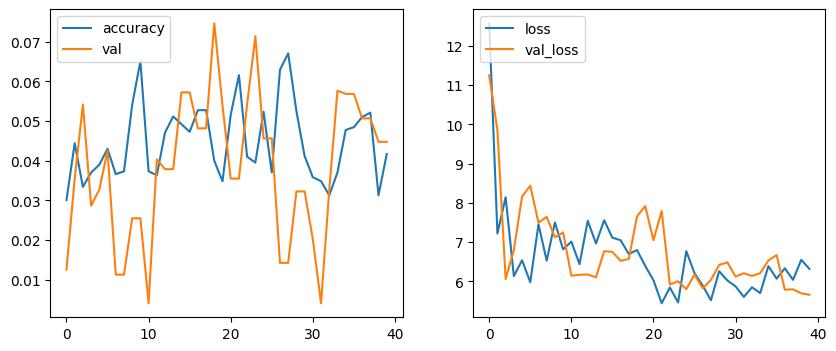

In [66]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

ax[0].plot(logs[0])
ax[0].plot(logs[2])
ax[0].legend(['accuracy', 'val'], loc='upper left')

ax[1].plot(logs[1])
ax[1].plot(logs[3])
ax[1].legend(['loss', 'val_loss'], loc='upper left')

plt.show()

In [92]:
index2word[np.argsort(model.predict(np.array([word2index["ai"],word2index["the"]]).reshape(1,2,1)))[0][-1]]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


'.'

## II.02.Summary :
#### *this a project requires a lot of resources and a lot of time for trainig... so i will not complite it...*